# Allen Cell Segmenter (Neurites Segmentation)

Here is the link: https://www.allencell.org/segmenter.html

It includes iterative deep learning workflow which means the model can be improved based on labelled images.

It is not very sensitive to parameters as was cellpose.

It works well for neurite mask detection (i.e. segmentation).

In [63]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d, edge_preserving_smoothing_3d
from skimage.morphology import remove_small_objects     # function for post-processing (size filter)

In [13]:
FILE_NAME = 'forFaraz/20240913_094939_873__WellC10_ChannelCSU 405,CSU 488,CSU 640_Seq0007_C10_0003_RGB_CSU 488.tif'
# FILE_NAME = 'forFaraz/20240913_094939_873__WellC10_ChannelCSU 405,CSU 488,CSU 640_Seq0007_C10_0003_RGB_CSU 640.tif'

reader = AICSImage(FILE_NAME) 
IMG = reader.data[0,0,0,:,:,0]

print(IMG.shape)

Failed to parse XML for the provided file.
no element found: line 1, column 0


(2048, 2048)


In [14]:
################################
## PARAMETERS for intensity normalization ##
intensity_scaling_param = [2.5, 7.5]
################################
struct_img = intensity_normalization(IMG, scaling_param=intensity_scaling_param)

In [15]:
################################
## PARAMETERS for this step ##
f2_param = [[1, 0.15]]
################################

bw = filament_2d_wrapper(struct_img, f2_param)

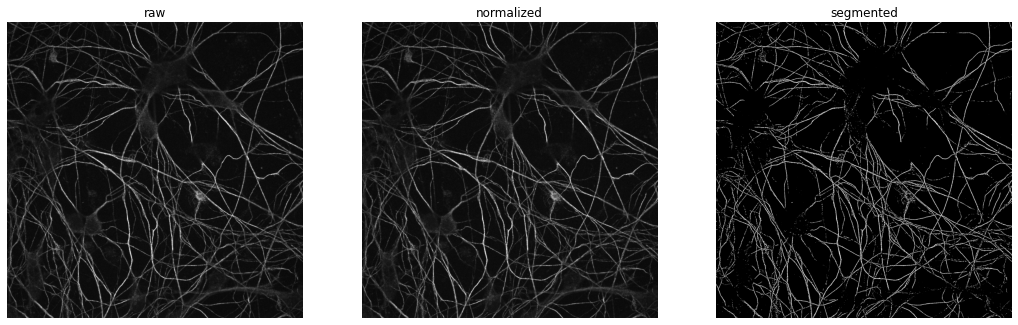

In [33]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
ax.imshow(IMG, cmap=plt.cm.gray)
ax2.imshow(struct_img, cmap=plt.cm.gray)
ax3.imshow(bw, cmap=plt.cm.gray)
ax.axis('off')
ax2.axis('off')
ax3.axis('off')
ax.set_title("raw")
ax2.set_title("normalized")
ax3.set_title("segmented")
plt.savefig(f"outputImages/ACSneuriteSegmentation_{FILE_NAME.split('/')[1].replace('.tif', '.png')}", bbox_inches='tight')

# Threshold's Otsu

Here is the link: https://scikit-image.org/docs/0.24.x/auto_examples/segmentation/plot_thresholding.html

It is a thresholding technique which basically divide bimodal distribution and make one modal to 0 and the other to 1.

It works well for neurite mask detection but couldn't remove bright spots, which was done better by allen cell segmenter.

In [38]:
import cv2
from skimage.filters import threshold_otsu

In [35]:
FILE_NAME = 'forFaraz/20240913_094939_873__WellC10_ChannelCSU 405,CSU 488,CSU 640_Seq0007_C10_0003_RGB_CSU 488.tif'
loaded_image = cv2.imread(FILE_NAME)
# FILE_NAME = 'forFaraz/20240913_094939_873__WellC10_ChannelCSU 405,CSU 488,CSU 640_Seq0007_C10_0003_RGB_CSU 640.tif'


In [32]:
loaded_image = np.array(loaded_image, dtype=float)[:, :, 0]
thresh = threshold_otsu(loaded_image)
binary = loaded_image > thresh


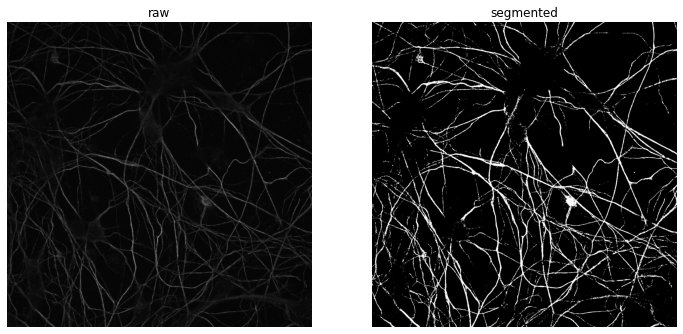

In [37]:
fig, (ax, ax3) = plt.subplots(1, 2, figsize=(12,16), dpi=72, facecolor='w', edgecolor='k')
ax.imshow(loaded_image, cmap=plt.cm.gray)
ax3.imshow(binary, cmap=plt.cm.gray)
ax.axis('off')
ax3.axis('off')
ax.set_title("raw")
ax3.set_title("segmented")
plt.savefig(f"outputImages/ThresholdOtsuneuriteSegmentation_{FILE_NAME.split('/')[1].replace('.tif', '.png')}", bbox_inches='tight')

# Cellpose

Here is the link: https://cellpose.readthedocs.io/en/latest/

It is a deep learning based segmentation technique. So it can be fine-tuned using labelled data to improve segmentation.

It is not designed for neurite segmentation task. The purpose of cellpose is to segment nucleus or cytoplasm. So, it didn't work nicely.

In [49]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io

In [ ]:
# view 1 image
filename = FILE_NAME
img = io.imread(FILE_NAME)
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [59]:
filename

'forFaraz/20240913_094939_873__WellC10_ChannelCSU 405,CSU 488,CSU 640_Seq0007_C10_0003_RGB_CSU 488.tif'

In [60]:
from cellpose import models, io
model = models.Cellpose(gpu=False, model_type='cyto')
channels = [[2,3], [0,0], [0,0]]
img = io.imread(filename)
masks, flows, styles, diams = model.eval(img, diameter=None, channels=chan)

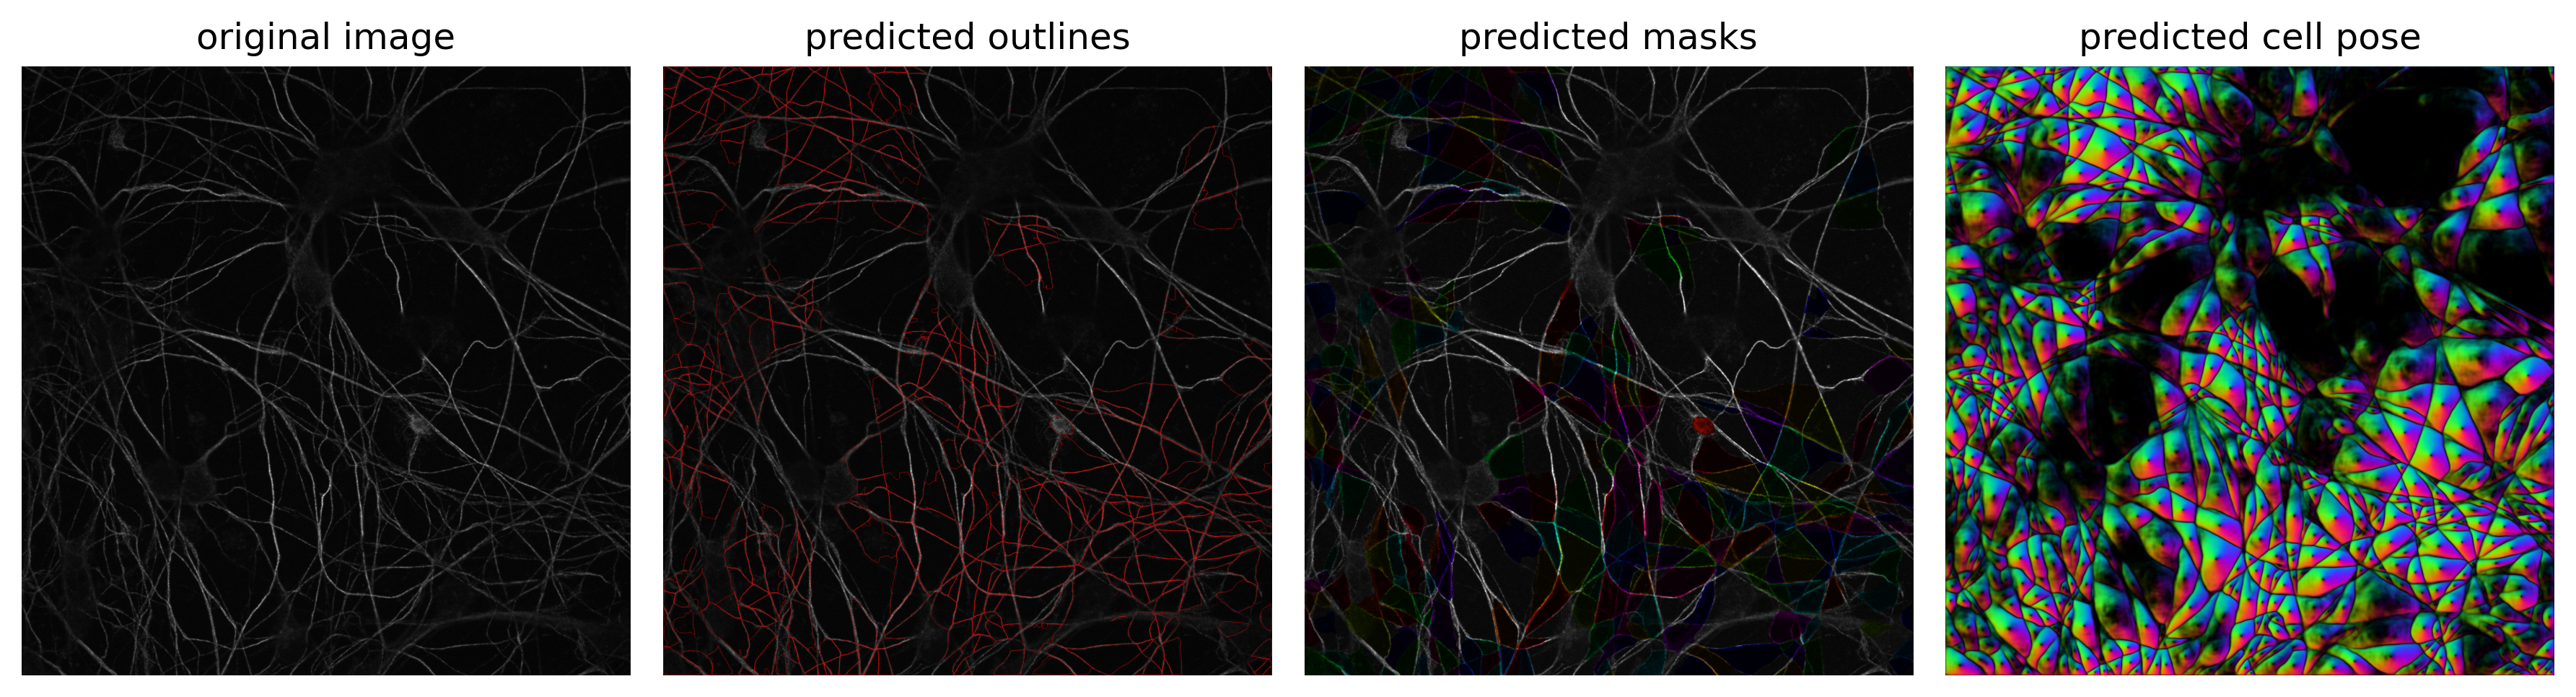

In [61]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()